In [5]:
import pandas as pd
import numpy as np
import time


dataset = pd.read_csv(r'hackathon_basketball_distribution.csv')

shotTypes = dataset.complexShotType.unique()
shotIds = [i for i in range(len(shotTypes))]

dataset['complexShotType'].replace(shotTypes, shotIds, inplace=True)

In [6]:
df1 = dataset.sample(frac=0.5, random_state=int(time.time()))
df2 = dataset.drop(df1.index)
dataset.head()


,player,season,fga3,fg3,period,startGameClock,shotClock,region,locX,locY,...,complexShotType,contestLevel,closestDefDist,rearViewContest,releaseTime,shotAngle,shooterSpeed,shooterVelAngle,rimDepth,rimLeftRight
0,"Murillo, Josue",2019,1,0,4,48.08,7.60,right wing three,-24.80,-18.64,...,0,lightly_contested,8.91,0,0.64,47.718662,0.131762,-66.153610,1.066764,-0.674009
1,"Castaneda, Urian",2019,1,1,4,37.42,1.80,right corner three,-44.74,-22.17,...,0,lightly_contested,8.34,0,0.84,97.680960,2.189780,13.513096,0.364760,0.096667
2,"Dean, Gregory",2021,1,1,2,297.60,8.36,middle three,-17.76,9.28,...,1,lightly_contested,6.96,0,1.20,-21.147858,1.133456,57.175232,1.681004,-0.661988
3,"Suazo, Garrett",2020,1,0,2,313.00,16.56,right wing three,-26.89,-20.08,...,1,uncontested,10.73,0,0.88,53.497086,2.296208,-41.983253,-0.663653,-0.857141
4,"Hatcher, Damian",2019,1,0,2,243.24,19.08,right wing three,-31.96,-22.33,...,1,uncontested,11.32,0,1.28,66.326220,1.166667,23.673782,-0.270286,0.182177


In [7]:
feature_cols = ['startGameClock', 'shotClock', 'distance', 'dribblesBefore', 'assistOpp', 'complexShotType', 'closestDefDist', 'rearViewContest', 'shotAngle', 'shooterSpeed', 'shooterVelAngle']
X = [df1.loc[:, feature_cols], df2.loc[:, feature_cols]]

Y = [df1['fg3'], df2['fg3']]

In [8]:
from sklearn import tree

clfs = [tree.DecisionTreeClassifier(), tree.DecisionTreeClassifier()] 

for i in range(len(clfs)):
    clfs[i] = clfs[i].fit(X[i], Y[i])

    
def getPredictedAndActualMade(clfs, x1, x2):
    sum1 = 0
    sum2 = 0
    if len(x2) > 0:
        sum1 = np.sum(clfs[0].predict(x2.loc[:, feature_cols]))
    if len(x1) > 0:
        sum2 = np.sum(clfs[1].predict(x1.loc[:, feature_cols])) 
    return  sum1 + sum2, np.sum(x1['fg3']) + np.sum(x2['fg3'])

In [9]:
predictions = np.zeros((2, X[0].shape[0]))
for i in range(len(clfs)):
    predictions[i] = clfs[i].predict(X[(i+1)%2])
    fg3Total = np.sum(predictions[i])/predictions[i].size*100
    print("For Model " + str(i + 1) + " " + str(fg3Total) + "% of the 3 pointers were made league wide.")


For Model 1 36.870775837792166% of the 3 pointers were made league wide.
For Model 2 36.85317516192622% of the 3 pointers were made league wide.


In [10]:
players = dataset.player.unique()
df = pd.DataFrame()
THRESHOLD = 200 # minimum predicted number of shots to be considered
base = 2
df['player_name'] = []
df['predicted_number_made'] = []
df['actual_number_made'] = []
df['percent_difference'] = []
df['fg%'] = []
df['predictedFg%'] = []
df['attempts'] = []
df['metric'] = []

def write_to_dataframe(df, name, pred, actual, percentDifficulty, fg, predictedFg, attempts):
    metric = np.cbrt(attempts)*(fg + percentDifficulty)
    return df.append({'player_name' : name, 'predicted_number_made' : 
                        pred, 'actual_number_made' : actual, 
                        'percent_difference': percentDifficulty, 
                        'fg%' :  fg, 'predictedFg%' : predictedFg, 'attempts' : attempts, 'metric': metric}, 
                       ignore_index = True)

for player in players:
    pS = [df1[df1['player'] == player], df2[df2['player'] == player]]
    attemptedShots = len(pS[0]) + len(pS[1])
    if attemptedShots > THRESHOLD:
        predicted_total, actual_total = getPredictedAndActualMade(clfs, pS[0], pS[1])
        percentDifference = (actual_total - predicted_total)/predicted_total

        fgPercent = actual_total/attemptedShots
        predictedPercent = predicted_total/attemptedShots
        
        df = write_to_dataframe(df, player, predicted_total, actual_total, percentDifference, fgPercent, predictedPercent, attemptedShots)

/tmp/ipykernel_479/1933485262.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append({'player_name' : name, 'predicted_number_made' :
/tmp/ipykernel_479/1933485262.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append({'player_name' : name, 'predicted_number_made' :
/tmp/ipykernel_479/1933485262.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append({'player_name' : name, 'predicted_number_made' :
/tmp/ipykernel_479/1933485262.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append({'player_name' : name, 'predicted_number_made' :
/tmp/ipykernel_479/1933485262.py:16: FutureWarni

In [11]:
df.sort_values(by = ['metric'], ascending=False).head(50)

,player_name,predicted_number_made,actual_number_made,percent_difference,fg%,predictedFg%,attempts,metric
184,"Collins, Damon",540.0,634.0,0.174074,0.383313,0.326481,1654.0,6.591772
109,"Miramontes-Granillo, Andrew",361.0,424.0,0.174515,0.452026,0.384861,938.0,6.133151
290,"Jensen, Zachery",188.0,242.0,0.287234,0.419411,0.325823,577.0,5.882922
90,"Gibb-Morgan, Richard",686.0,737.0,0.074344,0.408763,0.380477,1803.0,5.879974
31,"Pollock, Daquan",499.0,561.0,0.124248,0.398155,0.354152,1409.0,5.856563
51,"Simon, Larinso",545.0,604.0,0.108257,0.390433,0.352295,1547.0,5.767586
151,"Yetemegn, Shaquille",580.0,634.0,0.093103,0.396250,0.362500,1600.0,5.723513
124,"Aguilera, Anthony",750.0,796.0,0.061333,0.384727,0.362494,2069.0,5.683908
113,"Araujo-Mendoza, Fabian",467.0,520.0,0.113490,0.399386,0.358679,1302.0,5.600360
97,"Hurd, Eris",299.0,346.0,0.157191,0.439086,0.379442,788.0,5.507528


Text(0, 0.5, 'Player')

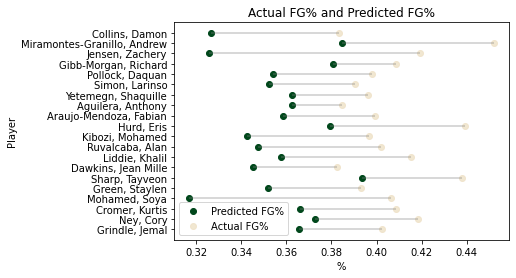

In [12]:
import matplotlib.pyplot as plt

predicted_made = df['predicted_number_made']
actual_made = df['actual_number_made']
metricplot = df['metric']

#plt.scatter(predicted_made, actual_made)

ordered_df = df.sort_values(by='metric', ascending=False).head(20)
my_range=range(1,len(ordered_df.index)+1)

plt.hlines(y=my_range, xmin=ordered_df['predictedFg%'], xmax=ordered_df['fg%'], color='grey', alpha=0.4)
plt.scatter(ordered_df['predictedFg%'], my_range, color='#00471B', alpha=1, label='Predicted FG%')
plt.scatter(ordered_df['fg%'], my_range, color='#EEE1C6', alpha=0.8 , label='Actual FG%')
plt.legend()

# Add title and axis names
plt.yticks(my_range, ordered_df['player_name'])
plt.title("Actual FG% and Predicted FG%", loc='center')
plt.ylim(max(my_range) + 1, min(my_range) - 1)
plt.xlabel('%')
plt.ylabel('Player')

Feature: 0, Score: 0.13748
Feature: 1, Score: 0.12469
Feature: 2, Score: 0.14016
Feature: 3, Score: 0.02444
Feature: 4, Score: 0.00511
Feature: 5, Score: 0.02943
Feature: 6, Score: 0.13028
Feature: 7, Score: 0.00252
Feature: 8, Score: 0.13296
Feature: 9, Score: 0.13229
Feature: 10, Score: 0.14065


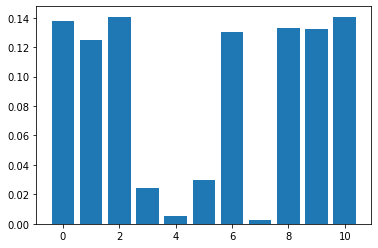

In [30]:

# decision tree for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

# get importance
importance = clfs[0].feature_importances_
importance = clfs[1].feature_importances_
# summarize feature importance

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
